In [1]:
#precision, recall, fscore
jobs = [
"ppi-bert-2021-01-02-08-56-37-716",
"ppi-bert-2021-01-02-08-56-29-913",
"ppi-bert-2021-01-02-08-56-19-909",
"ppi-bert-2021-01-02-08-56-14-194",
"ppi-bert-2021-01-02-08-56-10-043",
"ppi-bert-2021-01-02-08-56-05-246",
"ppi-bert-2021-01-02-08-55-52-783",
"ppi-bert-2021-01-02-08-55-44-461",
"ppi-bert-2021-01-02-08-55-34-954",
"ppi-bert-2021-01-02-08-55-25-173"
]

In [2]:
data_dir = "temp"

s3_model_single_path = "s3://aegovan-data/results/{}/output/output.tar.gz".format(jobs[0])
s3_model_path_format = "s3://aegovan-data/results/{}/output/output.tar.gz"

In [3]:
!pip install scikit-plot==0.3.7


You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [5]:
!rm -rf $data_dir
!mkdir $data_dir


In [6]:
import os

download_single_file(s3_model_single_path, os.path.join(data_dir, s3_model_single_path.split("/")[-1] ))

In [7]:
!tar -xf $data_dir/output.tar.gz -C $data_dir


In [8]:
!rm $data_dir/output.tar.gz


In [9]:
!ls -l $data_dir

total 6712
-rw-r--r--  1 aeg  staff  3424590 Jan  2 21:58 predicted.json
-rw-r--r--  1 aeg  staff     3564 Jan  2 21:58 training_scores_epoch_Objectdump_20210102_105808_d12fb863-6f26-4261-9a06-4a69c7be5a4b.json
-rw-r--r--  1 aeg  staff     3570 Jan  2 21:58 validation_scores_epoch_Objectdump_20210102_105808_c7452648-cdef-4562-8e46-88490a8dcab4.json


In [10]:
import tarfile
import pandas as pd
import json
from pandas.io.json import json_normalize
import tempfile 
import os
import boto3
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
import scikitplot as skplt

In [11]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [12]:
import glob, os

single_test_results_file = os.path.join(data_dir, "predicted.json")
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [13]:
import pandas as pd

In [14]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [15]:
df_single_test_results = pd.read_json(single_test_results_file)
df_single_test_results["actual"] = df_single_test_results["class"]

In [16]:
df_single_test_results.columns


Index(['pubmedId', 'pubmedabstract', 'annotations',
       'num_unique_gene_normalised_id', 'num_gene_normalised_id',
       'normalised_abstract', 'participant1Id', 'participant2Id',
       'gene_to_uniprot_map', 'class', 'predicted', 'confidence_scores',
       'actual'],
      dtype='object')

In [17]:
df_single_test_results.shape

(720, 13)

In [18]:
df_single_test_results.head(n=2)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class,predicted,confidence_scores,actual
0,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,P51817,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 0.0001179631, 'demethylation':...",other
1,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,O43541,Q02363,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 0.0001640779, 'demethylation':...",other


In [19]:
df_single_test_results.query("predicted == 'phosphorylation'").sample(n=5)["confidence_scores"].iloc[1]

{'acetylation': 0.0009765917,
 'demethylation': 0.0004508006,
 'dephosphorylation': 0.0006135250000000001,
 'deubiquitination': 0.0003613653,
 'methylation': 0.0004898856,
 'other': 0.0175595991,
 'phosphorylation': 0.9788860679,
 'ubiquitination': 0.0006622432}

## Analyse Results

In [20]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [21]:
df_single_test_results.shape

(720, 13)

In [22]:
def get_flattened_confidence_scores(df):
    df = df.copy(deep=True)
    keys = list(df["confidence_scores"][0].keys())
    
    for k in keys:
        df[k]  =df["confidence_scores"].apply(lambda x: x[k])

    df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]), axis=1 )
    
    return df

def get_f_scores(df):
    from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

    scores = {}
    scores["F1_macro"] = f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["precision_macro"]  = precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["recall_macro"] = recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["F1_micro"]  = f1_score(df["actual"], df["predicted"], average='micro' ,sample_weight=None)  
    scores["accuracy"] = accuracy_score(df["actual"], df["predicted"],sample_weight=None)
    
    
    return scores

def plot_confusion_matrix(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt


    skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True , figsize=(5,5),  x_tick_rotation=90)
    plt.savefig("confusionmatrix_normalised.png", bbox_inches='tight')

    skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], figsize=(4,4), normalize=False, x_tick_rotation=90 )
    plt.savefig("confusionmatrix_unnormalised.png", bbox_inches='tight')





In [23]:
df_single_test_results = get_flattened_confidence_scores(df_single_test_results)

In [24]:
df_single_test_results.head(n=3)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class,predicted,confidence_scores,actual,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,predicted_confidence
0,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,P51817,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 0.0001179631, 'demethylation':...",other,0.000118,0.000085,0.000285,0.000117,0.000133,0.998127,0.000929,0.000206,0.998127
1,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,O43541,Q02363,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 0.0001640779, 'demethylation':...",other,0.000164,0.000116,0.000339,0.000130,0.000189,0.997322,0.001442,0.000298,0.997322
10,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,Q92917,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 0.0001308669, 'demethylation':...",other,0.000131,0.000097,0.000299,0.000118,0.000155,0.998266,0.000708,0.000226,0.998266


In [25]:

get_f_scores(df_single_test_results)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'F1_macro': 0.5883303939805489,
 'precision_macro': 0.6403979338715642,
 'recall_macro': 0.5691085074345945,
 'F1_micro': 0.9013888888888889,
 'accuracy': 0.9013888888888889}

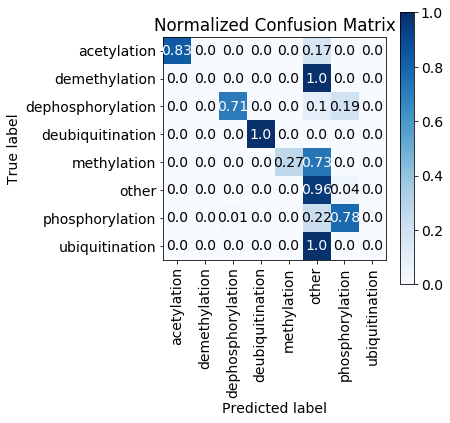

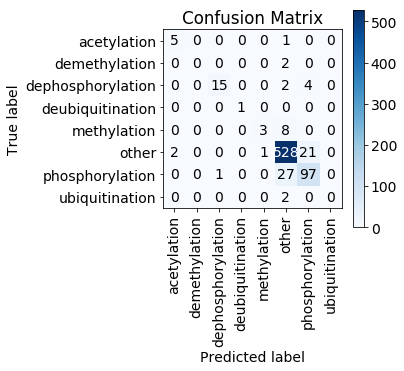

In [26]:
plot_confusion_matrix(df_single_test_results)

In [27]:
def plot_pr_curve(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    keys = list(df["confidence_scores"][0].keys())
    
    skplt.metrics.plot_precision_recall(df_single_test_results["actual"], df_single_test_results[keys], figsize=(5,5)).legend(bbox_to_anchor=(1,1))



In [28]:
def plot_roc_curve(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    keys = list(df["confidence_scores"][0].keys())


    skplt.metrics.plot_roc(df_single_test_results["actual"], df_single_test_results[keys], figsize=(5,5)).legend(bbox_to_anchor=(1,1))





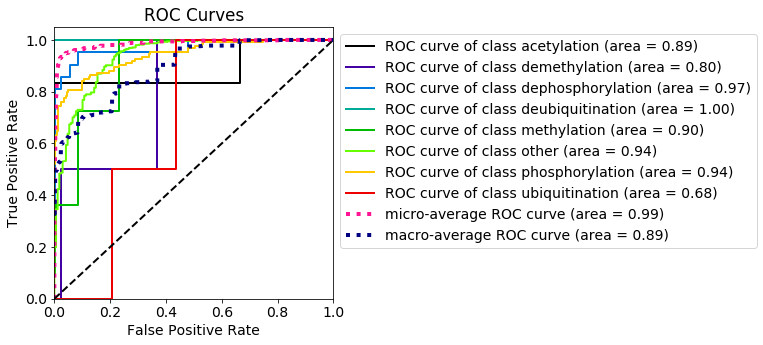

In [29]:
plot_roc_curve(df_single_test_results)

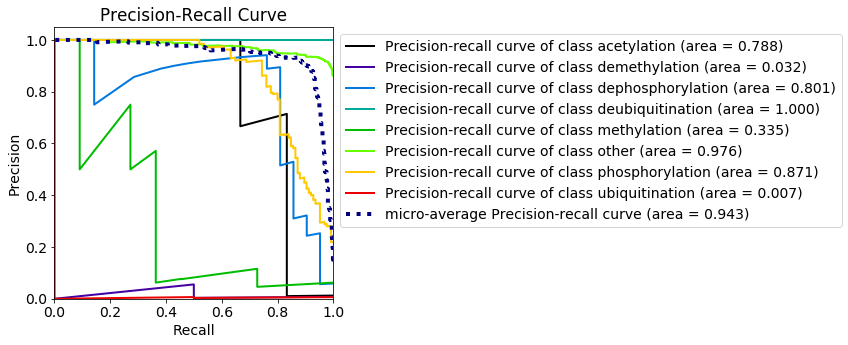

In [30]:
plot_pr_curve(df_single_test_results)


## Training / Validation epoch fit

In [31]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [32]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] =df_train_fit["score"]* 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
37,37,5.458566,98.853272
49,49,3.955004,98.758006
38,38,6.711910,98.611909
41,41,6.923091,98.064057
34,34,9.206827,97.915101
48,48,2.754267,96.940929
44,44,3.478390,96.885952
42,42,5.353969,96.866413
47,47,2.958368,96.821699
40,40,5.306303,96.767949


In [33]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] =df_val_fit["score"]* 100


df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
28,28,30.258541,58.765263
25,25,35.030780,53.273151
24,24,33.663091,52.552781
22,22,30.993883,51.744211
18,18,26.499587,50.670773
48,48,40.787115,50.625690
45,45,37.119598,50.256151
31,31,29.440736,49.812144
19,19,27.021797,49.762549
42,42,34.510135,49.762514


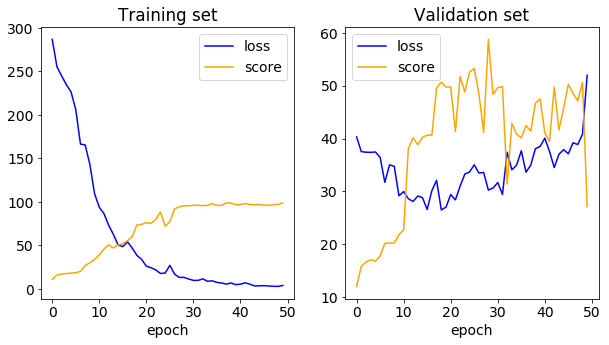

In [34]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color="orange")
ax[0].set_title("Training set")
#ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color ="orange")
ax[1].set_title("Validation set")
#ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

## Variation Bert - Objective F-score

In [35]:
import boto3
import re

def search_log(stream_names, filter_pattern, regex_pattern):
    client = boto3.client('logs')

    log_group_name= "/aws/sagemaker/TrainingJobs"

    response = client.filter_log_events(
        logGroupName=log_group_name,
        logStreamNames=stream_names,
        filterPattern= filter_pattern,
        limit=10,
        interleaved=False
    )
    assert len(response["events"]) == 1
    log_message = response["events"][0]["message"]
    
    # extract the cm from string
    prog = re.compile(regex_pattern)
    result = prog.match(log_message)
    
    return result



def get_prf(stream_names, filterPattern):
    regex_pattern = ".*precision, recall, fscore, support\s+\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    result = search_log(stream_names, filterPattern, regex_pattern).group(1)

    # normalise string to remove extra space
    result = re.sub("\s+", "", result) 
    
    # split the string, sep by comma..514 62 41 75
    precision, recall, fscore = result.split(",")
    
    return float(precision), float(recall), float(fscore)


    
def get_val_macro_score(stream_names):
    filterPattern =  '"__main__ - INFO - macro average scores"'
    return get_prf(stream_names, filterPattern)

def get_val_micro_score(stream_names):
    filterPattern =  '"__main__ - INFO - micro average scores"'
    return get_prf(stream_names, filterPattern)

def get_log_name(sagemaker_job_name):
    client = boto3.client('logs')
    log_group_name= "/aws/sagemaker/TrainingJobs"
    
    response = client.describe_log_streams(
    logGroupName=log_group_name,
    logStreamNamePrefix=sagemaker_job_name,
    orderBy='LogStreamName',
    descending=False,
    limit=5
)
    assert len(response["logStreams"]) == 1
    
    return  response["logStreams"][0]["logStreamName"]

In [36]:
import pandas as pd

val_scores = []
for j in jobs:
    l = get_log_name(j)
    precision, recall, fmacro = get_val_macro_score([l])
    fmicro = get_val_micro_score([l])[2]
    val_scores.append({"jobname": j, "precision":precision*100, "recall": recall*100, "f1-macro": fmacro*100,"f1-micro": fmicro*100})

df_val_variation_scores = pd.DataFrame(val_scores)

In [37]:
df_val_variation_scores .describe()

,f1-macro,f1-micro,precision,recall
count,10.000000,10.000000,10.000000,10.000000
mean,60.486629,85.683060,66.434928,57.673648
std,5.748217,1.858459,6.301306,7.543788
min,55.190652,82.240437,58.621596,50.227354
25%,58.768980,85.519126,62.799670,53.990333
50%,59.099315,86.065574,66.314886,55.010741
75%,60.728824,86.338798,66.870851,58.199069
max,75.782581,88.797814,82.248408,76.910132


In [38]:
best_val_job = df_val_variation_scores.iloc[df_val_variation_scores["f1-macro"].idxmax()]["jobname"]

In [39]:
df_val_variation_scores.head(n=10)

,f1-macro,f1-micro,jobname,precision,recall
0,58.765263,86.338798,ppi-bert-2021-01-02-08-56-37-716,65.494204,54.602578
1,55.190652,83.060109,ppi-bert-2021-01-02-08-56-29-913,58.621596,52.837451
2,59.354377,86.338798,ppi-bert-2021-01-02-08-56-19-909,65.955643,55.171858
3,58.844253,85.519126,ppi-bert-2021-01-02-08-56-14-194,66.674130,53.786251
4,58.780130,82.240437,ppi-bert-2021-01-02-08-56-10-043,61.901491,57.312925
5,61.041468,86.885246,ppi-bert-2021-01-02-08-56-05-246,66.723509,58.494450
6,75.782581,88.797814,ppi-bert-2021-01-02-08-55-52-783,82.248408,76.910132
7,59.790894,86.065574,ppi-bert-2021-01-02-08-55-44-461,68.029344,54.849624
8,55.655619,85.519126,ppi-bert-2021-01-02-08-55-34-954,66.919965,50.227354
9,61.661056,86.065574,ppi-bert-2021-01-02-08-55-25-173,61.780994,62.543860


In [40]:
df_val_variation_scores.iloc[df_val_variation_scores["f1-macro"].idxmax()]

f1-macro                              75.7826
f1-micro                              88.7978
jobname      ppi-bert-2021-01-02-08-55-52-783
precision                             82.2484
recall                                76.9101
Name: 6, dtype: object

In [41]:
from sklearn.metrics import classification_report
import sklearn


def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


def load_scores_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    
def get_predictions(s3_path):
    tmp_dir = tempfile.mkdtemp()
    outfile = os.path.join(tmp_dir, "output.tar.gz" )
    download_single_file(s3_path, outfile)
    tf = tarfile.open(outfile)
    tf.extractall(path=tmp_dir)
    test_input_file = os.path.join(tmp_dir, "predicted.json")


    df_results =  pd.read_json(test_input_file)
    df_results["actual"] = df_results["class"]
    
    validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(tmp_dir))[0]
    train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(tmp_dir))[0]

    df_val_fit = load_scores_as_df(validation_fit_file)
    df_train_fit = load_scores_as_df(train_fit_file)



    return df_results, df_val_fit, df_train_fit



def create_classification_report(actual, pred, labels=None):
    score_report_dict = sklearn.metrics.classification_report(actual, pred, output_dict=True, labels=labels)

    score_report_dict_transformed = []
    
    summary = {}
    for k, v in score_report_dict.items():
        if k in ["accuracy" ]: 
          
            summary[k] = v
        else:

            score_report_dict_transformed.append(
                {
                    "InteractionType" : k,
                    "precision" : v["precision"],
                    "recall" : v["recall"],
                    "f1-score" : v["f1-score"],
                    "support" : v["support"]
                }
            )
        
    return pd.DataFrame(score_report_dict_transformed), summary
    
def get_all_classification_report(list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        labels = list(set(df["actual"].unique().tolist()) - set(['other']))
        df_classification_summary,_ = create_classification_report(df["actual"], df["predicted"], labels=labels)
        df_classification_summary["keypath"] = s3_path
        

        scores.append(df_classification_summary)
        
    return pd.concat(scores)




def get_all_scores (list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        score = {}
        score["key"]=s3_path
        score["F1-score"] = 100*f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
        score["Precision"]  =100* precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
        score["Recall"] = 100*recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None) 
        score["Accuracy"] = 100*accuracy_score(df["actual"], df["predicted"])  


        scores.append(score)
        
    return pd.DataFrame(scores)


def get_ensemble (list_of_s3_path):
    scores = {}

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        scores[s3_path] = df
        
    return scores

In [42]:
%%time

s3_model_paths = []
for k in jobs:
    s3_path = s3_model_path_format.format(k)
    s3_model_paths.append(s3_path)

df_test_variation_scores =  get_all_scores(s3_model_paths)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

CPU times: user 1.15 s, sys: 367 ms, total: 1.52 s
Wall time: 39 s


In [43]:
df_test_variation_scores.describe()

,Accuracy,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000
mean,88.680556,49.595190,52.212377,49.745812
std,1.285087,9.251926,10.020005,10.995755
min,86.666667,33.840146,37.156673,32.820530
25%,87.569444,43.095352,44.789785,42.777623
50%,89.236111,48.983135,49.317274,49.275626
75%,89.687500,57.012480,62.058746,54.519965
max,90.138889,63.816941,65.822353,73.056315


In [44]:
df_test_variation_scores.head(n=2)

,Accuracy,F1-score,Precision,Recall,key
0,90.138889,58.833039,64.039793,56.910851,s3://aegovan-data/results/ppi-bert-2021-01-02-...
1,89.722222,48.312740,49.809715,47.022920,s3://aegovan-data/results/ppi-bert-2021-01-02-...


In [45]:
df_test_variation_scores.query("key == '{}'".format(s3_model_path_format.format(best_val_job)))

,Accuracy,F1-score,Precision,Recall,key
6,89.722222,49.65353,48.824834,51.528331,s3://aegovan-data/results/ppi-bert-2021-01-02-...


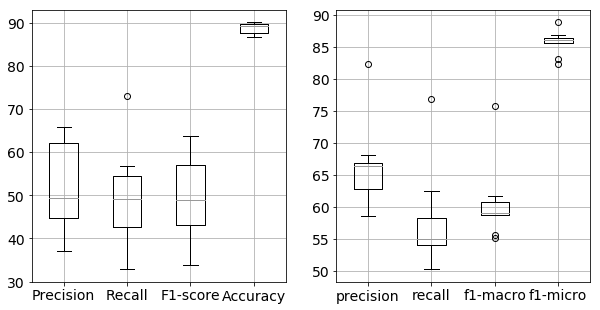

In [46]:

fig, ax = plt.subplots(1,2, figsize=(10, 5))
plt.style.use('grayscale')

df_test_variation_scores[["Precision", "Recall", "F1-score", "Accuracy"]].boxplot(ax=ax[0] )
#ax.set_title( "BERT Variation - PPI typed dataset" )

df_val_variation_scores[["precision", "recall", "f1-macro", "f1-micro"]].boxplot(ax=ax[1] ) 

plt.savefig("score_variation_typed.pdf", bbox_inches='tight')





### Ensemble results

In [47]:
%%time

s3_model_paths = []
for k in jobs:
    job_name = k 
    s3_path = s3_model_path_format.format(job_name)
    s3_model_paths.append(s3_path)

ensemble_results =  get_ensemble(s3_model_paths)

CPU times: user 893 ms, sys: 364 ms, total: 1.26 s
Wall time: 36.9 s


In [48]:
import statistics
import numpy as np

vote_base="votes_{}"
raw_key_base="raw_{}"
def populate_ensemble_predicted_confidence(ensemble_results):
    base_df= ensemble_results[0]
    keys = list(base_df["confidence_scores"][0].keys())
    vote_keys = [ vote_base.format(k) for k in keys]
    result = base_df[["actual", "normalised_abstract", "participant1Id", "participant2Id", "num_unique_gene_normalised_id", "num_gene_normalised_id"]  ]
    result["index"] = base_df.index
    for v in vote_keys :
        result[v] = 0.0
    for k in  keys:
         result[raw_key_base.format(k)] = [[]]* result.shape[0]
      
    # Get confidence scores
    for df in ensemble_results:
        df = get_flattened_confidence_scores(df)

        for k in keys:
        
            result[raw_key_base.format(k)] = result[raw_key_base.format(k)] + df[k].apply(lambda x: [x])
            result[vote_base.format(k)] += df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)

    
    for k in keys:        
        result[k] = result.apply(lambda r:np.mean(r[raw_key_base.format(k)]), axis=1) 
            
    raw_keys = [raw_key_base.format(k) for k in keys]
    # populate voting
    result["ensemble_predicted_confidence"] =  result.apply(lambda r: max( r[ keys].values), axis=1 )
    result["ensemble_predicted"] =  result.apply(lambda r: keys[np.argmax( r[ keys].values)], axis=1 )


    result["ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))], axis=1 )
    result["ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    
    return result

In [49]:
def get_one_vs_rest_confidence(df, key_columns, prediction_key, prediction_confidence_key ):
    new_df = pd.DataFrame()
    for k in key_columns:
        new_df[k] = df.apply(lambda r: r[prediction_confidence_key] if r[prediction_key]==k else 1-r[prediction_confidence_key]  ,  axis=1)
        
    return new_df
    

In [50]:
def get_best_result(df_dict, best_val_key):
    for k in df_dict:
        if best_val_key in k:
            return k,  df_dict[k]
      

In [51]:
k, best_raw_df = get_best_result(ensemble_results, best_val_job)



In [52]:
best_raw_df.head()

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class,predicted,confidence_scores,actual
0,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,P51817,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 1.6759800000000002e-05, 'demet...",other
1,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,O43541,Q02363,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 1.68791e-05, 'demethylation': ...",other
10,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,Q92917,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 2.1376e-05, 'demethylation': 2...",other
100,9808624,MAP kinase (MAPK) cascades are composed of a M...,"[{'start': '78', 'end': '90', 'name': 'MAPKK k...",5,24,MAP kinase (MAPK) cascades are composed of a M...,P01375,Q13233,"{'4216': ['Q9Y6R4', 'Q9P1M2'], '5599': ['P4598...",other,other,"{'acetylation': 2.08478e-05, 'demethylation': ...",other
101,9808624,MAP kinase (MAPK) cascades are composed of a M...,"[{'start': '78', 'end': '90', 'name': 'MAPKK k...",5,24,MAP kinase (MAPK) cascades are composed of a M...,P45983,Q13233,"{'4216': ['Q9Y6R4', 'Q9P1M2'], '5599': ['P4598...",other,other,"{'acetylation': 2.79901e-05, 'demethylation': ...",other


In [53]:
best_df = get_flattened_confidence_scores(best_raw_df)

In [54]:
best_df.sample(n=4)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class,predicted,confidence_scores,actual,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,predicted_confidence
168,10480872,The protein-tyrosine phosphatase PTP-1B is an ...,"[{'start': '33', 'end': '39', 'name': 'PTP-1B'...",4,18,The protein-tyrosine phosphatase P18031 is an ...,P18031,P02686,"{'1196': ['P49760', 'A8K7I0', 'B7Z8N6'], '5770...",other,other,"{'acetylation': 0.00028848780000000003, 'demet...",other,0.000288,0.000241,0.001557,0.000085,0.000313,0.984813,0.012558,0.000144,0.984813
12,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,Q03014,Q92917,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': 1.97903e-05, 'demethylation': ...",other,0.000020,0.000024,0.000072,0.000010,0.000040,0.999683,0.000118,0.000033,0.999683
606,20577264,"In response to G2 DNA damage, the p53 pathway ...","[{'start': '34', 'end': '37', 'name': 'p53', '...",3,11,"In response to G2 DNA damage, the P04637 pathw...",P53350,Q9NYZ3,"{'5347': ['P53350'], '7157': ['P04637', 'K7PPA...",phosphorylation,phosphorylation,"{'acetylation': 7.71717e-05, 'demethylation': ...",phosphorylation,0.000077,0.000054,0.000898,0.000145,0.000114,0.000243,0.998363,0.000105,0.998363
249,12640114,beta-Catenin has a key role in the formation o...,"[{'start': '0', 'end': '12', 'name': 'beta-Cat...",6,25,P35222 has a key role in the formation of adhe...,P35221,P12830,"{'1499': ['P35222', 'B4DGU4', 'A0A024R2Q3'], '...",other,other,"{'acetylation': 1.69788e-05, 'demethylation': ...",other,0.000017,0.000020,0.000054,0.000010,0.000037,0.999770,0.000053,0.000039,0.999770


In [55]:
%%time

df_ensemble = populate_ensemble_predicted_confidence(list(ensemble_results.values()))

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


CPU times: user 8.41 s, sys: 160 ms, total: 8.57 s
Wall time: 8.85 s


In [56]:
df_ensemble.query("ensemble_predicted == 'acetylation'").head(n=3)

,actual,normalised_abstract,participant1Id,participant2Id,num_unique_gene_normalised_id,num_gene_normalised_id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,raw_acetylation,raw_demethylation,raw_dephosphorylation,raw_deubiquitination,raw_methylation,raw_other,raw_phosphorylation,raw_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction
574,acetylation,"The enzyme inositol 1,3,4-trisphosphate 5/6-ki...",Q13572-1,Q92793,4,15,574,6.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,"[0.6156670451, 0.759455204, 0.0016076589, 0.02...","[0.020982815000000002, 0.0192456041, 0.0005526...","[0.0428776108, 0.079963699, 0.0552429520000000...","[0.0314964987, 0.0257829595, 0.0051933047, 0.0...","[0.021202635, 0.014851985500000001, 0.00094021...","[0.1415231228, 0.0732590407, 0.0009094532, 0.0...","[0.0563830175, 0.0143721122, 0.9340704083, 0.0...","[0.0698671788, 0.0130694229, 0.0014833778, 0.0...",0.497990,0.021002,0.238609,0.025216,0.028742,0.031866,0.136479,0.020097,0.497990,acetylation,acetylation,0.497990
582,acetylation,Np63 is a Q9H3D4 isoform that is predominantly...,O88898-2,Q92831,3,4,582,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.869075954, 0.9226039052, 0.9733669758000001...","[0.0230728444, 0.0121459579, 0.0035494997, 0.0...","[0.0071391589, 0.006918334900000001, 0.0004520...","[0.02892223, 0.017121292700000002, 0.007214451...","[0.0311337393, 0.0094591239, 0.0048946459, 0.0...","[0.0022177999, 0.015137665900000001, 0.0003987...","[0.0092309071, 0.0069262199, 0.0047686412, 0.0...","[0.0292072222, 0.0096875923, 0.0053548762, 0.0...",0.859276,0.013215,0.006238,0.057149,0.010308,0.005962,0.019123,0.028729,0.859276,acetylation,acetylation,0.859276
583,acetylation,Np63 is a Q9H3D4 isoform that is predominantly...,O88898-2,Q92831,3,4,583,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.869075954, 0.9226039052, 0.9733669758000001...","[0.0230728444, 0.0121459579, 0.0035494997, 0.0...","[0.0071391589, 0.006918334900000001, 0.0004520...","[0.02892223, 0.017121292700000002, 0.007214451...","[0.0311337393, 0.0094591239, 0.0048946459, 0.0...","[0.0022177999, 0.015137665900000001, 0.0003987...","[0.0092309071, 0.0069262199, 0.0047686412, 0.0...","[0.0292072222, 0.0096875923, 0.0053548762, 0.0...",0.859276,0.013215,0.006238,0.057149,0.010308,0.005962,0.019123,0.028729,0.859276,acetylation,acetylation,0.859276


In [57]:
t= "acetylation"
df_ensemble.query(f"ensemble_predicted == '{t}'")[ raw_key_base.format(t)].iloc[0]

[0.6156670451,
 0.759455204,
 0.0016076589,
 0.0246556066,
 0.875308454,
 0.0029773971,
 0.989883244,
 0.9526827931,
 0.2232504338,
 0.5344112515]

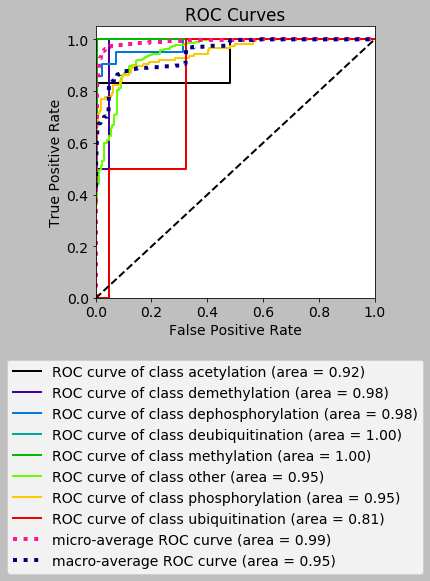

In [58]:

import matplotlib.pyplot as plt
import scikitplot as skplt
keys = list(best_df["confidence_scores"][0].keys())


skplt.metrics.plot_roc(df_ensemble["actual"], df_ensemble[keys], figsize=(5,5)).legend(bbox_to_anchor=(1.2,-0.2))


plt.savefig("plot_roc_ensemble.eps", bbox_inches='tight')


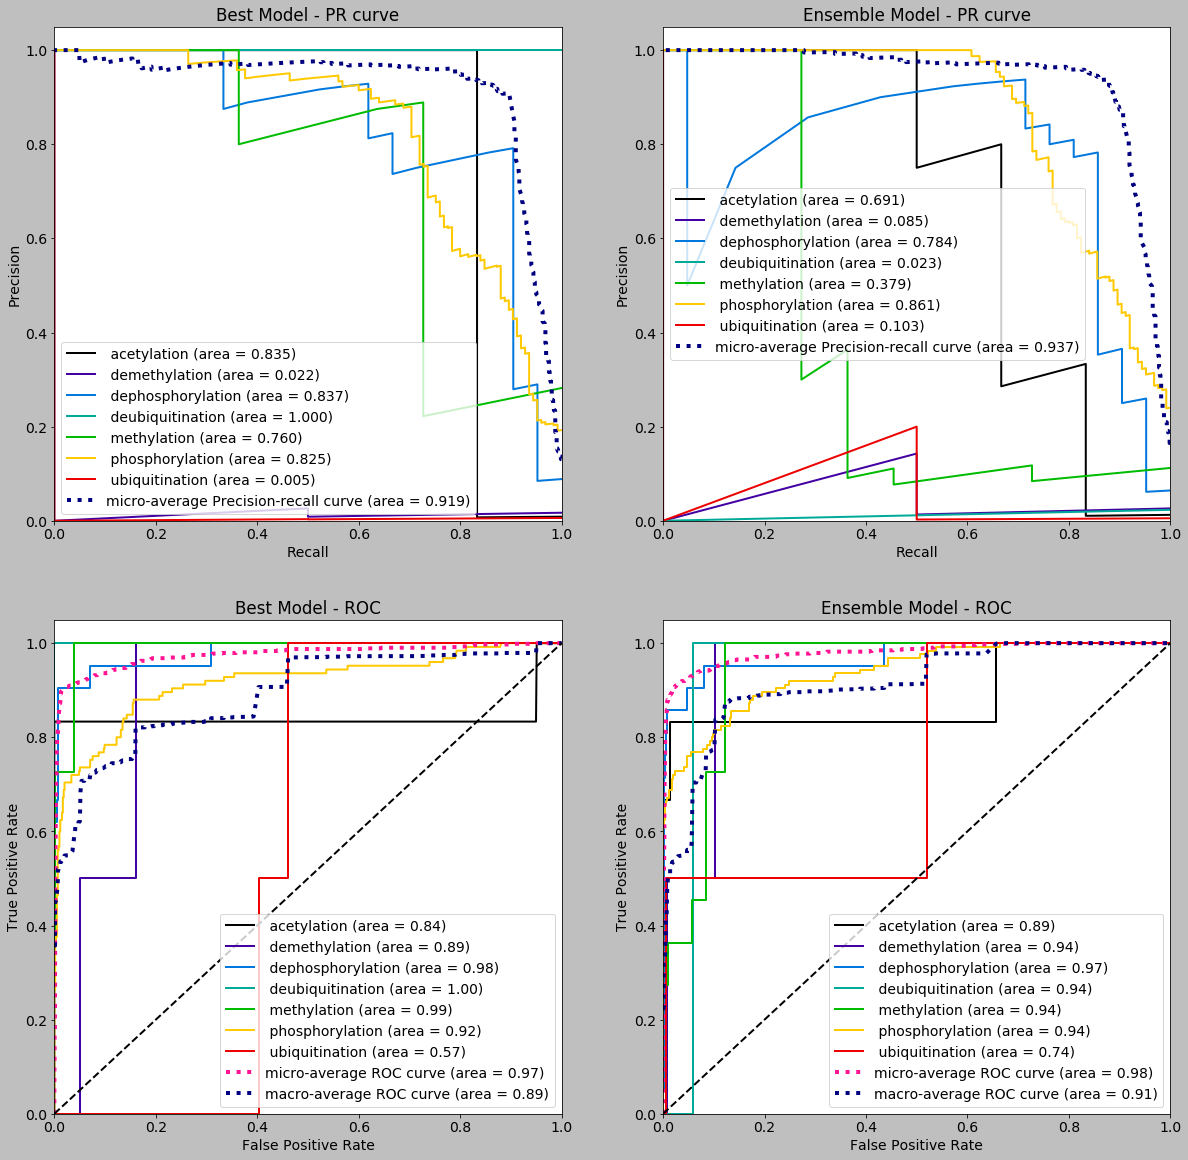

In [59]:

import matplotlib.pyplot as plt
import scikitplot as skplt
classes_to_plot = list( set(list(best_df["confidence_scores"][0].keys()))-set(['other']))

keys = list(best_df["confidence_scores"][0].keys())

fig, ax = plt.subplots(2,2, figsize=(20,20))
ax= ax.reshape(-1)

axi=ax[0]
skplt.metrics.plot_precision_recall(best_df["actual"], get_one_vs_rest_confidence(best_df, keys,"predicted", "predicted_confidence" ), ax=axi, title="Best Model - PR curve", classes_to_plot=classes_to_plot)
_, labels = axi.get_legend_handles_labels()
axi.legend([l.replace("Precision-recall curve of class","") for l in labels])

axi=ax[1]
skplt.metrics.plot_precision_recall(df_ensemble["actual"], get_one_vs_rest_confidence(df_ensemble, keys,"ensemble_predicted", "ensemble_predicted_confidence" ) , ax=axi,title="Ensemble Model - PR curve", classes_to_plot=classes_to_plot)
_, labels = axi.get_legend_handles_labels()
axi.legend([l.replace("Precision-recall curve of class","") for l in labels])


axi=ax[2]
skplt.metrics.plot_roc(best_df["actual"], get_one_vs_rest_confidence(best_df, keys,"predicted", "predicted_confidence" ), ax=axi, title="Best Model - ROC", classes_to_plot=classes_to_plot)
_, labels = axi.get_legend_handles_labels()
axi.legend([l.replace("ROC curve of class","") for l in labels])

axi=ax[3]
skplt.metrics.plot_roc(df_ensemble["actual"], get_one_vs_rest_confidence(df_ensemble, keys,"ensemble_predicted", "ensemble_predicted_confidence" ) , ax=axi,title="Ensemble Model - ROC", classes_to_plot=classes_to_plot).legend(bbox_to_anchor=(1.2,-0.2))
_, labels = axi.get_legend_handles_labels()
axi.legend([l.replace("ROC curve of class","") for l in labels])






plt.savefig("PlotPRCurveOnTest.pdf", bbox_inches='tight')



### Get Scores

In [60]:
df_ensemble.shape

(720, 35)

In [61]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"],sample_weight=None)
print(scores)



{'F1_macro': 0.606903352465488, 'precision_macro': 0.6318220470006184, 'recall_macro': 0.5915937794089968, 'F1_micro': 0.9083333333333333, 'accuracy': 0.9083333333333333}


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


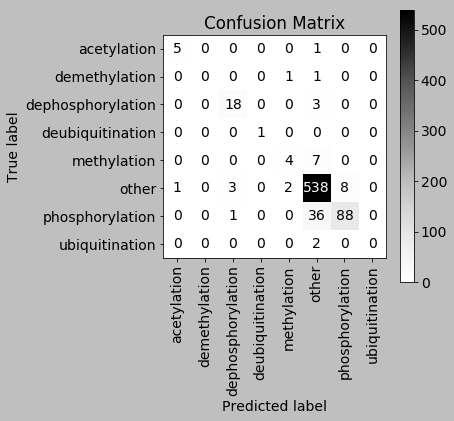

In [62]:
import matplotlib.pyplot as plt
import scikitplot as skplt

fig,ax = plt.subplots(1, 1, figsize=(5,5))


# skplt.metrics.plot_confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], normalize=True , ax=ax[0],  x_tick_rotation=90)
# plt.savefig("confusionmatrix_normalised.png", bbox_inches='tight')

skplt.metrics.plot_confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], ax=ax, normalize=False, x_tick_rotation=90, cmap="Greys" )
plt.savefig("confusionmatrix_unnormalised.eps", bbox_inches='tight')



In [63]:
from sklearn.metrics import confusion_matrix
# Specify label order
labels = ['other', 'acetylation','methylation','demethylation','phosphorylation','dephosphorylation','ubiquitination','deubiquitination'   ] 
confusion_df = pd.DataFrame(data= confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=labels), index=labels, columns=labels)

confusion_df.to_csv("confusion.matrix.csv")


In [64]:
confusion_df

,other,acetylation,methylation,demethylation,phosphorylation,dephosphorylation,ubiquitination,deubiquitination
other,538,1,2,0,8,3,0,0
acetylation,1,5,0,0,0,0,0,0
methylation,7,0,4,0,0,0,0,0
demethylation,1,0,1,0,0,0,0,0
phosphorylation,36,0,0,0,88,1,0,0
dephosphorylation,3,0,0,0,0,18,0,0
ubiquitination,2,0,0,0,0,0,0,0
deubiquitination,0,0,0,0,0,0,0,1


In [65]:
print(confusion_df.to_latex().replace("lation", ".").replace("ination", "."))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  other &  acety. &  methy. &  demethy. &  phosphory. &  dephosphory. &  ubiquit. &  deubiquit. \\
\midrule
other             &    538 &            1 &            2 &              0 &                8 &                  3 &               0 &                 0 \\
acety.       &      1 &            5 &            0 &              0 &                0 &                  0 &               0 &                 0 \\
methy.       &      7 &            0 &            4 &              0 &                0 &                  0 &               0 &                 0 \\
demethy.     &      1 &            0 &            1 &              0 &                0 &                  0 &               0 &                 0 \\
phosphory.   &     36 &            0 &            0 &              0 &               88 &                  1 &               0 &                 0 \\
dephosphory. &      3 &            0 &            0 &              0 &                0 &        

In [66]:
pos_labels = list(set(df_ensemble["actual"].unique().tolist()) - set(['other']))
df_ensemble_classwise_report, summary_ensemble = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
df_ensemble_classwise_report

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,InteractionType,f1-score,precision,recall,support
0,deubiquitination,1.000000,1.000000,1.000000,1
1,phosphorylation,0.796380,0.916667,0.704000,125
2,methylation,0.444444,0.571429,0.363636,11
3,acetylation,0.833333,0.833333,0.833333,6
4,dephosphorylation,0.837209,0.818182,0.857143,21
5,demethylation,0.000000,0.000000,0.000000,2
6,ubiquitination,0.000000,0.000000,0.000000,2
7,micro avg,0.773333,0.878788,0.690476,168
8,macro avg,0.558767,0.591373,0.536873,168
9,weighted avg,0.762011,0.857446,0.690476,168


In [67]:
pos_labels = list(set(best_df["actual"].unique().tolist()) - set(['other']))
best_df_classwise_report, summary_ensemble = create_classification_report(best_df["actual"], best_df["predicted"], labels=pos_labels)
best_df_classwise_report

,InteractionType,f1-score,precision,recall,support
0,deubiquitination,0.000000,0.000000,0.000000,1
1,phosphorylation,0.771930,0.854369,0.704000,125
2,methylation,0.761905,0.800000,0.727273,11
3,acetylation,0.769231,0.714286,0.833333,6
4,dephosphorylation,0.730769,0.612903,0.904762,21
5,demethylation,0.000000,0.000000,0.000000,2
6,ubiquitination,0.000000,0.000000,0.000000,2
7,micro avg,0.752351,0.794702,0.714286,168
8,macro avg,0.433405,0.425937,0.452767,168
9,weighted avg,0.743058,0.790195,0.714286,168


In [68]:
print(df_ensemble_classwise_report.merge( best_df_classwise_report,suffixes= ('.e', '.s'), on="InteractionType" ).drop("support.e", axis=1).sort_values(by=["InteractionType"]).to_latex(index=False, float_format =lambda x: "{:.2%}".format(x)).replace("\\%",""))

\begin{tabular}{lrrrrrrr}
\toprule
   InteractionType &  f1-score.e &  precision.e &  recall.e &  f1-score.s &  precision.s &  recall.s &  support.s \\
\midrule
       acetylation &      83.33 &       83.33 &    83.33 &      76.92 &       71.43 &    83.33 &          6 \\
     demethylation &       0.00 &        0.00 &     0.00 &       0.00 &        0.00 &     0.00 &          2 \\
 dephosphorylation &      83.72 &       81.82 &    85.71 &      73.08 &       61.29 &    90.48 &         21 \\
  deubiquitination &     100.00 &      100.00 &   100.00 &       0.00 &        0.00 &     0.00 &          1 \\
         macro avg &      55.88 &       59.14 &    53.69 &      43.34 &       42.59 &    45.28 &        168 \\
       methylation &      44.44 &       57.14 &    36.36 &      76.19 &       80.00 &    72.73 &         11 \\
         micro avg &      77.33 &       87.88 &    69.05 &      75.24 &       79.47 &    71.43 &        168 \\
   phosphorylation &      79.64 &       91.67 &    70.40 &    

In [69]:
pos_labels = ['acetylation','phosphorylation', 'methylation', 'dephosphorylation']
df_ensemble_sample_size_classwise_report, _ = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
best_df_sample_size_classwise_report,_= create_classification_report(best_df["actual"], best_df["predicted"], labels=pos_labels) 

df_ensemble_sample_size_classwise_report



,InteractionType,f1-score,precision,recall,support
0,acetylation,0.833333,0.833333,0.833333,6
1,phosphorylation,0.796380,0.916667,0.704000,125
2,methylation,0.444444,0.571429,0.363636,11
3,dephosphorylation,0.837209,0.818182,0.857143,21
4,micro avg,0.782313,0.877863,0.705521,163
5,macro avg,0.727842,0.784903,0.689528,163
6,weighted avg,0.779250,0.877613,0.705521,163


In [70]:
print(df_ensemble_sample_size_classwise_report.merge(best_df_sample_size_classwise_report, on="InteractionType", suffixes=[".e", ",b"]).drop("support.e", axis=1).to_latex(index=False, float_format =lambda x: "{:.2%}".format(x)).replace("\\%",""))

\begin{tabular}{lrrrrrrr}
\toprule
   InteractionType &  f1-score.e &  precision.e &  recall.e &  f1-score,b &  precision,b &  recall,b &  support,b \\
\midrule
       acetylation &      83.33 &       83.33 &    83.33 &      76.92 &       71.43 &    83.33 &          6 \\
   phosphorylation &      79.64 &       91.67 &    70.40 &      77.19 &       85.44 &    70.40 &        125 \\
       methylation &      44.44 &       57.14 &    36.36 &      76.19 &       80.00 &    72.73 &         11 \\
 dephosphorylation &      83.72 &       81.82 &    85.71 &      73.08 &       61.29 &    90.48 &         21 \\
         micro avg &      78.23 &       87.79 &    70.55 &      76.43 &       79.47 &    73.62 &        163 \\
         macro avg &      72.78 &       78.49 &    68.95 &      75.85 &       74.54 &    79.23 &        163 \\
      weighted avg &      77.93 &       87.76 &    70.55 &      76.59 &       81.44 &    73.62 &        163 \\
\bottomrule
\end{tabular}



In [71]:
df_ensemble["particpant1Exists"] = df_ensemble.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
df_ensemble["particpant2Exists"] = df_ensemble.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
df_ensemble["particpantsExists"] = df_ensemble.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)




In [72]:
df_ensemble.query("actual != ensemble_predicted  and  particpantsExists"  )[["ensemble_predicted", "actual","normalised_abstract", "participant1Id", "participant2Id"]].sample(n=10)

,ensemble_predicted,actual,normalised_abstract,participant1Id,participant2Id
632,other,phosphorylation,"P50613, a member of the cyclin-dependent prote...",P50613,P24941
80,phosphorylation,other,P56537 (P56537) controls translation by regula...,P04637,P56537
510,phosphorylation,other,Short-patch repair of DNA single-strand breaks...,Q96T60,P18887
708,other,methylation,The post-translational methylation of alpha-am...,P18754,Q9BV86
573,other,dephosphorylation,We have isolated the human genes encoding the ...,P28482,Q16829
668,other,phosphorylation,We report that two oncogenes coamplified on ch...,P48431,P41743
118,phosphorylation,other,O43561 is a linker protein essential for activ...,P43405,O43561
299,methylation,other,Signaling via the methylation of lysine residu...,Q8TBK2,Q04206
673,other,phosphorylation,Q16625 is an integral-membrane protein that co...,Q16625,P49674
666,other,phosphorylation,Maintenance of chromosomal stability relies on...,P33981,Q53HL2


In [125]:
df_ensemble.query("ensemble_predicted =='{0}' or actual == '{0}'".format("deubiquitination"))

,actual,normalised_abstract,participant1Id,participant2Id,num_unique_gene_normalised_id,num_gene_normalised_id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,raw_acetylation,raw_demethylation,raw_dephosphorylation,raw_deubiquitination,raw_methylation,raw_other,raw_phosphorylation,raw_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction,particpant1Exists,particpant2Exists,particpantsExists
690,deubiquitination,Mammalian P78317 is a dimeric RING ubiquitin E...,O88846,P51668,2,7,690,1.0,1.0,0.0,4.0,1.0,0.0,1.0,2.0,"[0.0515520014, 0.08722509440000001, 0.02461793...","[0.076574102, 0.0872692317, 0.0259067770000000...","[0.08030262590000001, 0.0100527182, 0.00720599...","[0.3439483345, 0.10646481070000001, 0.76474171...","[0.1273435503, 0.16673550010000002, 0.01089843...","[0.0017152242, 0.0138021652, 0.0044316091, 0.0...","[0.0897992477, 0.015013862400000001, 0.0110275...","[0.2287649512, 0.5134366155, 0.1511700302, 0.1...",0.129757,0.069305,0.021077,0.360909,0.115135,0.008353,0.066859,0.228604,0.360909,deubiquitination,deubiquitination,0.360909,False,True,False


In [73]:
df_ensemble.query("not particpantsExists").shape , df_ensemble.query("not particpantsExists and actual != ensemble_predicted").shape, df_ensemble.shape

((52, 38), (4, 38), (720, 38))

In [74]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"],sample_weight=None)
print(scores)



{'F1_macro': 0.6039544295396332, 'precision_macro': 0.6305156664420539, 'recall_macro': 0.5892731272350837, 'F1_micro': 0.9083333333333333, 'accuracy': 0.9083333333333333}


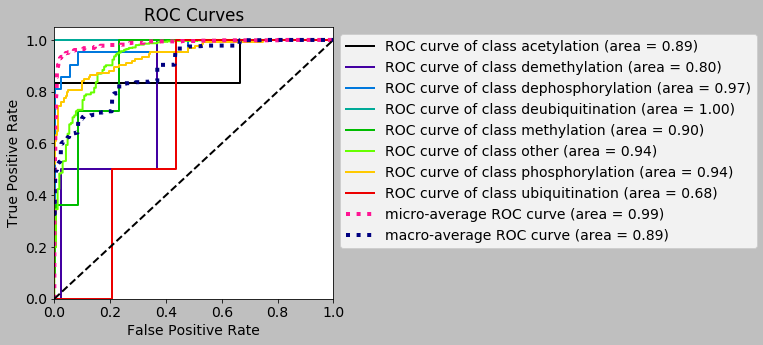

In [75]:
plot_roc_curve(df_single_test_results)

In [76]:
df_ensemble.head(n=2)

,actual,normalised_abstract,participant1Id,participant2Id,num_unique_gene_normalised_id,num_gene_normalised_id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,raw_acetylation,raw_demethylation,raw_dephosphorylation,raw_deubiquitination,raw_methylation,raw_other,raw_phosphorylation,raw_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction,particpant1Exists,particpant2Exists,particpantsExists
0,other,To gain insight into the function of human P51...,P10451,P51817,6,21,0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,"[0.0001179631, 0.0002559102, 3.58923e-05, 6.20...","[8.53095e-05, 0.0001291644, 3.82377e-05, 8.659...","[0.0002845387, 0.0002287896, 5.12358e-05, 7.45...","[0.0001171008, 0.0001288182, 3.02253e-05, 4.66...","[0.0001331279, 0.00019538740000000002, 5.12508...","[0.9981270432, 0.9984115362, 0.999677777300000...","[0.0009285568, 0.0004865402, 5.87212e-05, 0.00...","[0.0002063795, 0.00016371390000000002, 5.66551...",0.000130,0.000077,0.000200,0.000078,0.000122,0.998802,0.000455,0.000136,0.998802,other,other,0.998802,True,True,True
1,other,To gain insight into the function of human P51...,O43541,Q02363,6,21,1,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,"[0.0001640779, 0.0002671833, 3.73071e-05, 5.93...","[0.0001159037, 0.0001417731, 3.94417e-05, 7.12...","[0.0003387747, 0.0001984453, 5.17094e-05, 6.89...","[0.0001296369, 0.0001350061, 2.97932e-05, 3.88...","[0.0001890381, 0.00023029150000000002, 5.12317...","[0.9973223805, 0.9982429743000001, 0.999670982...","[0.0014417242, 0.0005858271000000001, 5.77038e...","[0.0002983725, 0.0001984535, 6.188230000000001...",0.000125,0.000076,0.000196,0.000073,0.000122,0.998181,0.001086,0.000142,0.998181,other,other,0.998181,True,True,True


In [77]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

def probability_threshold(df, confidence_field, predicted_field):
    result = []
    l, u = min(df[confidence_field]), max(df[confidence_field])
    threshold = 0
    step = round( (u-0)/50, 2)
    majority_class = df.groupby(["actual"]).size().idxmax()
    max_valuecounts =  df.groupby(["actual"]).size().max()
    while threshold <= u :
        df_filter = df.query("{} >=  {}".format(confidence_field, threshold))
        max_valuecounts_filter = df_filter.query("actual == '{}'".format(majority_class)).shape[0]


        result.append ({
            "baseline_accuracy" : max_valuecounts/df.shape[0],
            "baseline_accuracy_threshold" : max_valuecounts_filter/df_filter.shape[0],
            "threshold" : threshold,
            "records" : df_filter.shape[0],
            "percentage_records_retained" : df_filter.shape[0]/df.shape[0],
            "normalised_threshold" : (threshold -0 )/(u-0),
            "F1_macro": f1_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None)  ,
            "precision_macro":precision_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None) , 
            "recall_macro": recall_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None) , 
            "F1_micro":    f1_score(df_filter["actual"], df_filter[predicted_field], average='micro' ,sample_weight=None) ,
            "accuracy":accuracy_score(df_filter["actual"], df_filter[predicted_field],sample_weight=None)
        })
        threshold += step
        
    return pd.DataFrame(result)



In [78]:
pt_ensemble_majority_prediction = probability_threshold(df_ensemble,"ensemble_confidence_majority_prediction", "ensemble_majority_prediction")
pt_ensemble_prediction = probability_threshold(df_ensemble,"ensemble_predicted_confidence", "ensemble_predicted")
pt_best_prediction = probability_threshold(best_df,"predicted_confidence", "predicted")

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


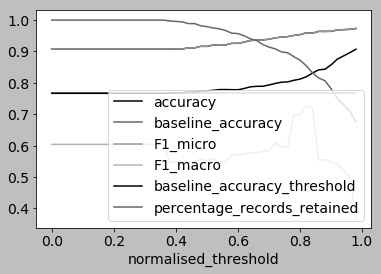

In [79]:
pt_ensemble_majority_prediction  [["normalised_threshold","accuracy", "baseline_accuracy" ,"F1_micro", "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold")

In [80]:
pt_ensemble_majority_prediction.sort_values(by=["normalised_threshold"], ascending=False).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
49,0.370068,0.973251,0.973251,0.766667,0.907407,0.981052,0.675000,0.394273,0.352381,486,0.98
48,0.502204,0.970646,0.970646,0.766667,0.896282,0.961030,0.709722,0.593658,0.451020,511,0.96
47,0.519464,0.969582,0.969582,0.766667,0.885932,0.941009,0.730556,0.543763,0.501852,526,0.94
46,0.540651,0.968519,0.968519,0.766667,0.875926,0.920987,0.750000,0.564885,0.523153,540,0.92
45,0.547563,0.964413,0.964413,0.766667,0.857651,0.900966,0.780556,0.572415,0.530000,562,0.90
44,0.554442,0.963855,0.963855,0.766667,0.843373,0.880945,0.806944,0.577871,0.537714,581,0.88
43,0.555275,0.964225,0.964225,0.766667,0.841567,0.860923,0.815278,0.577932,0.538961,587,0.86
42,0.721451,0.958264,0.958264,0.766667,0.831386,0.840902,0.831944,0.776519,0.682056,599,0.84
41,0.725331,0.959350,0.959350,0.766667,0.819512,0.820880,0.854167,0.776623,0.687888,615,0.82
40,0.698505,0.953822,0.953822,0.766667,0.812102,0.800859,0.872222,0.812754,0.638982,628,0.80


In [81]:
df_ensemble.query("ensemble_confidence_majority_prediction > 12095")["actual"].value_counts()

Series([], Name: actual, dtype: int64)

In [82]:
df_ensemble.to_json("test_ensemble.json")

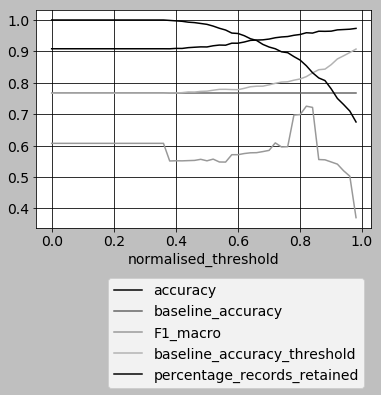

In [83]:
pt_ensemble_prediction   [["normalised_threshold","accuracy", "baseline_accuracy" , "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold", grid=True).legend(bbox_to_anchor=(1, -0.2))
plt.savefig("pb_threhold_ensmebl.png", bbox_inches='tight')

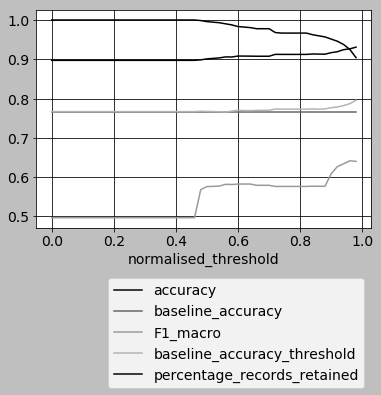

In [84]:
pt_best_prediction  [["normalised_threshold","accuracy", "baseline_accuracy" , "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold", grid=True).legend(bbox_to_anchor=(1, -0.2))
plt.savefig("pb_threhold_best.png", bbox_inches='tight')

In [85]:
pt_ensemble_prediction.sort_values(by=["threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.606903,0.908333,0.908333,0.766667,0.766667,0.000000,1.0,0.631822,0.591594,720,0.00
1,0.606903,0.908333,0.908333,0.766667,0.766667,0.020021,1.0,0.631822,0.591594,720,0.02
2,0.606903,0.908333,0.908333,0.766667,0.766667,0.040043,1.0,0.631822,0.591594,720,0.04
3,0.606903,0.908333,0.908333,0.766667,0.766667,0.060064,1.0,0.631822,0.591594,720,0.06
4,0.606903,0.908333,0.908333,0.766667,0.766667,0.080086,1.0,0.631822,0.591594,720,0.08
5,0.606903,0.908333,0.908333,0.766667,0.766667,0.100107,1.0,0.631822,0.591594,720,0.10
6,0.606903,0.908333,0.908333,0.766667,0.766667,0.120129,1.0,0.631822,0.591594,720,0.12
7,0.606903,0.908333,0.908333,0.766667,0.766667,0.140150,1.0,0.631822,0.591594,720,0.14
8,0.606903,0.908333,0.908333,0.766667,0.766667,0.160172,1.0,0.631822,0.591594,720,0.16
9,0.606903,0.908333,0.908333,0.766667,0.766667,0.180193,1.0,0.631822,0.591594,720,0.18


In [86]:
pt_best_prediction.sort_values(by=["normalised_threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.496535,0.897222,0.897222,0.766667,0.766667,0.000000,1.0,0.488248,0.515283,720,0.00
1,0.496535,0.897222,0.897222,0.766667,0.766667,0.020004,1.0,0.488248,0.515283,720,0.02
2,0.496535,0.897222,0.897222,0.766667,0.766667,0.040009,1.0,0.488248,0.515283,720,0.04
3,0.496535,0.897222,0.897222,0.766667,0.766667,0.060013,1.0,0.488248,0.515283,720,0.06
4,0.496535,0.897222,0.897222,0.766667,0.766667,0.080018,1.0,0.488248,0.515283,720,0.08
5,0.496535,0.897222,0.897222,0.766667,0.766667,0.100022,1.0,0.488248,0.515283,720,0.10
6,0.496535,0.897222,0.897222,0.766667,0.766667,0.120027,1.0,0.488248,0.515283,720,0.12
7,0.496535,0.897222,0.897222,0.766667,0.766667,0.140031,1.0,0.488248,0.515283,720,0.14
8,0.496535,0.897222,0.897222,0.766667,0.766667,0.160036,1.0,0.488248,0.515283,720,0.16
9,0.496535,0.897222,0.897222,0.766667,0.766667,0.180040,1.0,0.488248,0.515283,720,0.18


In [87]:
k

's3://aegovan-data/results/ppi-bert-2021-01-02-08-55-52-783/output/output.tar.gz'

In [88]:
pt_ensemble_majority_prediction.sort_values(by=["normalised_threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.603954,0.908333,0.908333,0.766667,0.766667,0.000000,1.0,0.630516,0.589273,720,0.00
1,0.603954,0.908333,0.908333,0.766667,0.766667,0.020021,1.0,0.630516,0.589273,720,0.02
2,0.603954,0.908333,0.908333,0.766667,0.766667,0.040043,1.0,0.630516,0.589273,720,0.04
3,0.603954,0.908333,0.908333,0.766667,0.766667,0.060064,1.0,0.630516,0.589273,720,0.06
4,0.603954,0.908333,0.908333,0.766667,0.766667,0.080086,1.0,0.630516,0.589273,720,0.08
5,0.603954,0.908333,0.908333,0.766667,0.766667,0.100107,1.0,0.630516,0.589273,720,0.10
6,0.603954,0.908333,0.908333,0.766667,0.766667,0.120129,1.0,0.630516,0.589273,720,0.12
7,0.603954,0.908333,0.908333,0.766667,0.766667,0.140150,1.0,0.630516,0.589273,720,0.14
8,0.603954,0.908333,0.908333,0.766667,0.766667,0.160172,1.0,0.630516,0.589273,720,0.16
9,0.603954,0.908333,0.908333,0.766667,0.766667,0.180193,1.0,0.630516,0.589273,720,0.18


## Gene mentions impact

In [89]:
print(df_ensemble.query("actual != 'other'")["num_unique_gene_normalised_id"].describe(percentiles= [ f/100 for f in range(0,110, 10)]).to_latex(float_format = lambda x:  '{:.2f}'.format(x)))

\begin{tabular}{lr}
\toprule
{} &  num\_unique\_gene\_normalised\_id \\
\midrule
count &                         168.00 \\
mean  &                           3.54 \\
std   &                           1.83 \\
min   &                           1.00 \\
0\%    &                           1.00 \\
10\%   &                           1.00 \\
20\%   &                           2.00 \\
30\%   &                           2.00 \\
40\%   &                           3.00 \\
50\%   &                           3.00 \\
60\%   &                           4.00 \\
70\%   &                           5.00 \\
80\%   &                           5.00 \\
90\%   &                           6.00 \\
100\%  &                           9.00 \\
max   &                           9.00 \\
\bottomrule
\end{tabular}



In [90]:
df_ensemble.query("actual != 'other'")\
.groupby(["actual"])["num_unique_gene_normalised_id"]\
.describe(percentiles= [ f/100 for f in range(0,110, 10)])

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
actual,,,,,,,,,,,,,,,,
acetylation,6.0,3.500000,1.378405,2.0,2.0,2.5,3.0,3.0,3.0,3.0,3.0,3.5,4.0,5.0,6.0,6.0
demethylation,2.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
dephosphorylation,21.0,3.619048,1.687489,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,5.0,6.0,6.0,6.0,6.0
deubiquitination,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
methylation,11.0,2.818182,0.404520,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
phosphorylation,125.0,3.560000,1.952666,1.0,1.0,1.0,2.0,2.0,3.0,3.0,4.0,5.0,5.0,6.0,9.0,9.0
ubiquitination,2.0,5.000000,1.414214,4.0,4.0,4.2,4.4,4.6,4.8,5.0,5.2,5.4,5.6,5.8,6.0,6.0


In [117]:
print(df_ensemble.query("actual != 'other'")\
.groupby(["actual"])["num_unique_gene_normalised_id"]\
.describe()\
.to_latex(float_format = lambda x:  '{:.2f}'.format(x), formatters={"count": lambda x:str(int(x))}))

\begin{tabular}{lrrrrrrrr}
\toprule
{} & count &  mean &  std &  min &  25\% &  50\% &  75\% &  max \\
actual            &       &       &      &      &      &      &      &      \\
\midrule
acetylation       &     6 &  3.50 & 1.38 & 2.00 & 3.00 & 3.00 & 3.75 & 6.00 \\
demethylation     &     2 &  5.00 & 0.00 & 5.00 & 5.00 & 5.00 & 5.00 & 5.00 \\
dephosphorylation &    21 &  3.62 & 1.69 & 2.00 & 2.00 & 3.00 & 5.00 & 6.00 \\
deubiquitination  &     1 &  2.00 &  nan & 2.00 & 2.00 & 2.00 & 2.00 & 2.00 \\
methylation       &    11 &  2.82 & 0.40 & 2.00 & 3.00 & 3.00 & 3.00 & 3.00 \\
phosphorylation   &   125 &  3.56 & 1.95 & 1.00 & 2.00 & 3.00 & 5.00 & 9.00 \\
ubiquitination    &     2 &  5.00 & 1.41 & 4.00 & 4.50 & 5.00 & 5.50 & 6.00 \\
\bottomrule
\end{tabular}



In [92]:
from datetime import datetime
def summarize_impact_unique_gene_count(df):
    
    size_genes = df ["num_unique_gene_normalised_id"] .unique().tolist()
    
    pos_labels = list(set(df["actual"].unique().tolist()) - set(['other']))

    frames =[]
    for i in  size_genes:
        print(datetime.now(),"Running for size ", i)
        
        df_size = df.query("num_unique_gene_normalised_id == {}".format(i))

        df_class_wise_report,_ = create_classification_report(df_size["actual"], df_size["ensemble_predicted"], labels=pos_labels)
        
        df_class_wise_report["unique_gene_count"] = i
        
        frames.append(df_class_wise_report)
        
    df = pd.concat(frames)
    
    return df


In [93]:
df_size_summary = summarize_impact_unique_gene_count(df_ensemble)

2021-01-10 22:00:39.087000 Running for size  6
2021-01-10 22:00:39.099968 Running for size  5
2021-01-10 22:00:39.115031 Running for size  4
2021-01-10 22:00:39.127846 Running for size  7
2021-01-10 22:00:39.151349 Running for size  3
2021-01-10 22:00:39.158928 Running for size  2
2021-01-10 22:00:39.165849 Running for size  8
2021-01-10 22:00:39.172537 Running for size  9
2021-01-10 22:00:39.179341 Running for size  1


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [94]:
df_size_summary

,InteractionType,f1-score,precision,recall,support,unique_gene_count
0,deubiquitination,0.000000,0.000000,0.000000,0,6
1,phosphorylation,0.782609,1.000000,0.642857,14,6
2,methylation,0.000000,0.000000,0.000000,0,6
3,acetylation,0.000000,0.000000,0.000000,1,6
4,dephosphorylation,0.727273,0.666667,0.800000,5,6
5,demethylation,0.000000,0.000000,0.000000,0,6
6,ubiquitination,0.000000,0.000000,0.000000,1,6
7,micro avg,0.722222,0.866667,0.619048,21,6
8,macro avg,0.215697,0.238095,0.206122,21,6
9,weighted avg,0.694899,0.825397,0.619048,21,6


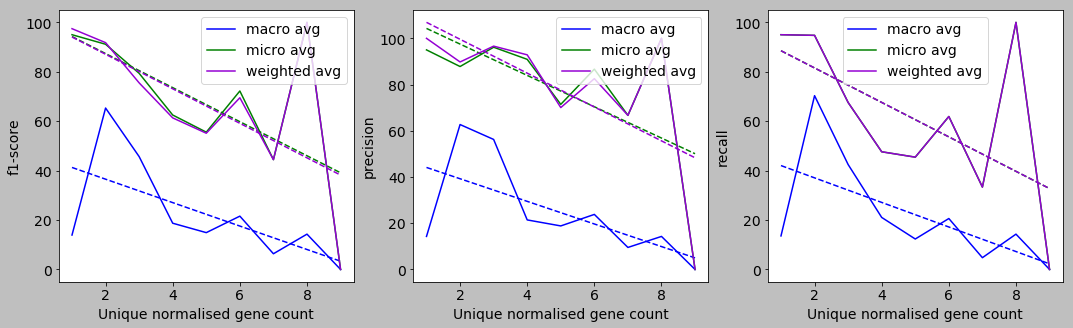

In [95]:
import numpy

fig, ax = plt.subplots(1, 3 , figsize=(18,5))


colors = ['blue', 'green',  "darkviolet"]

def plot(axis, score='f1-score'):
    for c, (label, df_e) in zip(colors, df_size_summary.query("InteractionType in ['micro avg', 'macro avg', 'weighted avg']").groupby('InteractionType')):
        d = df_e.sort_values(by="unique_gene_count")
        d[score] = d[score].apply( lambda x: float( '{:.2%}'.format(x).replace("%", "")) )
        d.plot.line( ax=axis, label=label, x="unique_gene_count" , y=score, color=c  )
        z = numpy.polyfit(d["unique_gene_count"], d[score], 1)
        p = numpy.poly1d(z)
        axis.plot( d["unique_gene_count"], p(d["unique_gene_count"]), color=c ,  linestyle='dashed'  )
        axis.set_xlabel("Unique normalised gene count")
        axis.set_ylabel(score)

    axis.legend()

plot(ax[0], 'f1-score')

plot(ax[1], 'precision')

plot(ax[2], 'recall')

plt.savefig("GeneCountVsScore.pdf", bbox_inches="tight")


plt.show()



## Ensemble size impact

In [96]:
from datetime import datetime
def summarize_impact_ensemble_size(jobs):
    """
    Summarize impact of ensemble_size on prediction
    """
    s3_model_paths = []
    for k in jobs:
        job_name = k 
        s3_path = s3_model_path_format.format(job_name)
        s3_model_paths.append(s3_path)
    
    
    frames = []
    scores = []
    
    for i in range(1, len(s3_model_paths)):
        print(datetime.now(),"Running for ensemble ", i)
        # Compute individual scores
        df_score = get_all_classification_report(s3_model_paths[:i])
        df_score["ensemble_size"] = i
        scores.append(df_score)
        
        #Compute ensemble scores
        ensemble_results =  get_ensemble(s3_model_paths[:i])
        df_ensemble = populate_ensemble_predicted_confidence(list(ensemble_results.values()))
        
        pos_labels = list(set(df_ensemble["actual"].unique().tolist()) - set(['other']))


        df_class_wise_report,_ = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
        
        df_class_wise_report["ensemble_size"] = i
        
        frames.append(df_class_wise_report)
        
    df = pd.concat(frames)
    df_scores =  pd.concat(scores)
    
    return df, df_scores
        
        

In [97]:
%%time

df_ensemble_size_compare, df_ensemble_scores = summarize_impact_ensemble_size(jobs)

2021-01-10 22:00:40.321067 Running for ensemble  1


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

2021-01-10 22:00:50.549486 Running for ensemble  2


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/pyt

2021-01-10 22:01:08.935733 Running for ensemble  3


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

2021-01-10 22:01:33.783002 Running for ensemble  4


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2021-01-10 22:02:08.691381 Running for ensemble  5


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2021-01-10 22:02:47.525825 Running for ensemble  6


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2021-01-10 22:03:33.239056 Running for ensemble  7


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2021-01-10 22:04:27.142251 Running for ensemble  8


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2021-01-10 22:05:32.520999 Running for ensemble  9


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

CPU times: user 1min 2s, sys: 4.43 s, total: 1min 6s
Wall time: 5min 56s


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
df_ensemble_scores .query("InteractionType=='{}'".format("phosphorylation")).groupby("ensemble_size").describe()

f1-score                                                    \
                 count      mean       std       min       25%       50%   
ensemble_size                                                              
1                  1.0  0.785425       NaN  0.785425  0.785425  0.785425   
2                  2.0  0.781834  0.005079  0.778243  0.780038  0.781834   
3                  3.0  0.772385  0.016755  0.753488  0.765866  0.778243   
4                  4.0  0.761937  0.024976  0.730594  0.747765  0.765866   
5                  5.0  0.751655  0.031567  0.710526  0.730594  0.753488   
6                  6.0  0.739055  0.041829  0.676056  0.715543  0.742041   
7                  7.0  0.743752  0.040156  0.676056  0.720560  0.753488   
8                  8.0  0.733721  0.046766  0.663507  0.701909  0.742041   
9                  9.0  0.737514  0.045201  0.663507  0.710526  0.753488   

                                  precision                                \
                    75%       max     count      mean       std       min   
ensemble_size                                                               
1              0.785425  0.785425       1.0  0.795082       NaN  0.795082   
2              0.783629  0.785425       2.0  0.805436  0.014642  0.795082   
3              0.781834  0.785425       3.0  0.836957  0.055570  0.795082   
4              0.780038  0.785425       4.0  0.840484  0.045918  0.795082   
5              0.778243  0.785425       5.0  0.829669  0.046542  0.786408   
6              0.772054  0.785425       6.0  0.827754  0.041892  0.786408   
7              0.775086  0.785425       7.0  0.831556  0.039543  0.786408   
8              0.773508  0.785425       8.0  0.829356  0.037135  0.786408   
9              0.771930  0.785425       9.0  0.833726  0.037128  0.786408   

                                                      recall            \
                    25%       50%       75%       max  count      mean   
ensemble_size                                                            
1              0.795082  0.795082  0.795082  0.795082    1.0  0.776000   
2              0.800259  0.805436  0.810613  0.815789    2.0  0.760000   
3              0.805436  0.815789  0.857895  0.900000    3.0  0.722667   
4              0.810613  0.833427  0.863298  0.900000    4.0  0.702000   
5              0.795082  0.815789  0.851064  0.900000    5.0  0.691200   
6              0.800259  0.816986  0.842843  0.900000    6.0  0.672000   
7              0.805436  0.818182  0.852716  0.900000    7.0  0.676571   
8              0.809236  0.816986  0.851890  0.900000    8.0  0.662000   
9              0.813953  0.818182  0.854369  0.900000    9.0  0.664889   

                                                           support         \
                    std    min    25%    50%    75%    max   count   mean   
ensemble_size                                                               
1                   NaN  0.776  0.776  0.776  0.776  0.776     1.0  125.0   
2              0.022627  0.744  0.752  0.760  0.768  0.776     2.0  125.0   
3              0.066613  0.648  0.696  0.744  0.760  0.776     3.0  125.0   
4              0.068313  0.640  0.646  0.696  0.752  0.776     4.0  125.0   
5              0.063900  0.640  0.648  0.648  0.744  0.776     5.0  125.0   
6              0.074016  0.576  0.642  0.648  0.720  0.776     6.0  125.0   
7              0.068641  0.576  0.644  0.648  0.724  0.776     7.0  125.0   
8              0.075744  0.560  0.624  0.648  0.714  0.776     8.0  125.0   
9              0.071380  0.560  0.640  0.648  0.704  0.776     9.0  125.0   

                                                       
               std    min    25%    50%    75%    max  
ensemble_size                                          
1              NaN  125.0  125.0  125.0  125.0  125.0  
2              0.0  125.0  125.0  125.0  125.0  125.0  
3              0.0  125.0  125.0  125.0  125.0  125.0  
4              0.0  125.0 

In [99]:
df_ensemble_size_compare.query("InteractionType not in [ 'weighted avg']").groupby([ 'InteractionType', "ensemble_size"]).head()

,InteractionType,f1-score,precision,recall,support,ensemble_size
0,deubiquitination,1.000000,1.000000,1.000000,1,1
1,phosphorylation,0.785425,0.795082,0.776000,125,1
2,methylation,0.400000,0.750000,0.272727,11,1
3,acetylation,0.769231,0.714286,0.833333,6,1
4,dephosphorylation,0.810811,0.937500,0.714286,21,1
5,demethylation,0.000000,0.000000,0.000000,2,1
6,ubiquitination,0.000000,0.000000,0.000000,2,1
7,micro avg,0.761006,0.806667,0.720238,168,1
8,macro avg,0.537924,0.599553,0.513764,168,1
0,deubiquitination,0.000000,0.000000,0.000000,1,2


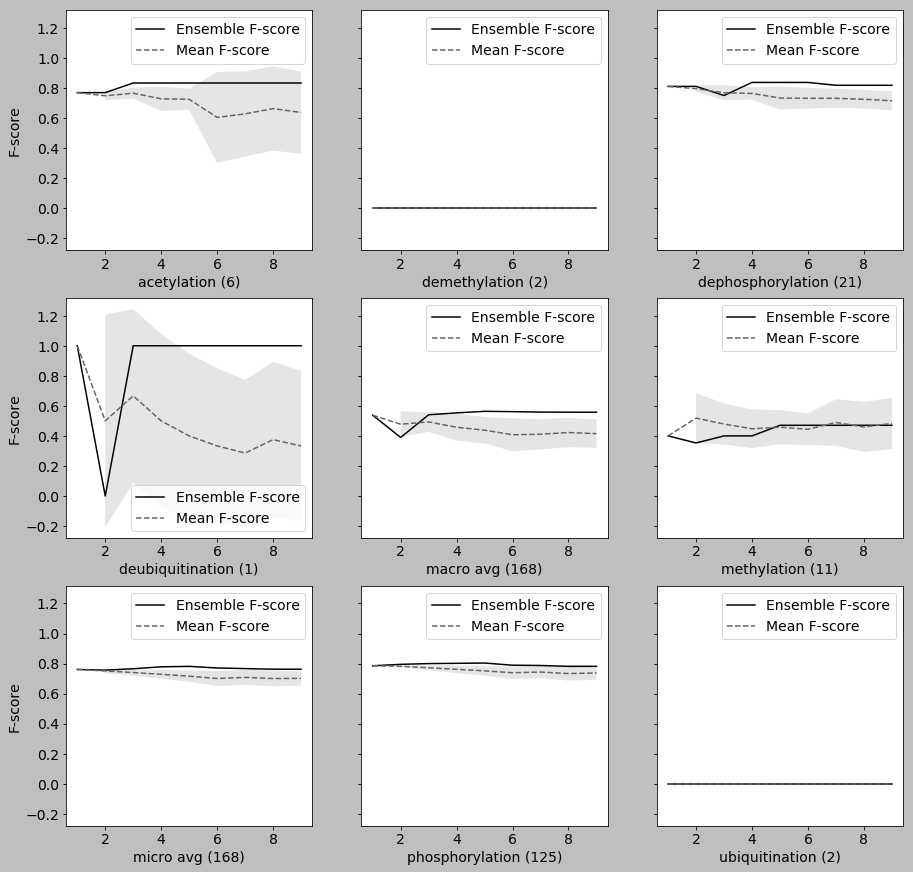

In [100]:
fig, axo = plt.subplots(3,3,figsize=(15,15), sharex=False, sharey=True)
ax=axo.reshape(-1)
colors = ["pink", "red", "blue", "green", "orange", "black", "lime", "mediumblue", "peru"]
line_type = []

for  i, (c, (label, df_e)) in enumerate(zip(colors, df_ensemble_size_compare.query("InteractionType not in [ 'weighted avg']").groupby('InteractionType'))):
    support = df_e["support"].iloc[0]
    df_e = df_e.sort_values(by=["ensemble_size"])


    df_v = df_ensemble_scores.query("InteractionType=='{}'".format(label)).groupby("ensemble_size").std()
    
    df_m = df_ensemble_scores.query("InteractionType=='{}'".format(label)).groupby("ensemble_size").mean()
    
    df_e.plot.line( ax=ax[i],label="Ensemble F-score" , x="ensemble_size" , y="f1-score")
    ax[i].plot(df_m.index.values , df_m["f1-score"].values, linestyle="dashed", label= "{}".format("Mean F-score"))
    ax[i].legend()
    
    ax[i].fill_between( df_v.index.values, df_m["f1-score"].values - df_v["f1-score"].values, df_m["f1-score"].values + df_v["f1-score"].values, alpha=0.1)
    ax[i].set_xlabel( "{} ({})".format(label, str(support))) 
    ax[i].set_ylabel( "F-score") 



plt.savefig("EnsembleSizeImpact.pdf")


plt.show()

### Ensemble size impact on PR curve

In [101]:
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import label_binarize


def compute_average_precison(list_of_dfs, normalise=True, predicted_key="ensemble_predicted", predicted_key_confi=  "ensemble_predicted_confidence"):
    result = []
    for df in list_of_dfs:
        if normalise:
            df = get_flattened_confidence_scores(df)
            predicted_key="predicted" 
            predicted_key_confi=  "predicted_confidence"


        pos_labels = df["actual"].unique().tolist()
        pos_labels.remove("other")

        y = label_binarize(df["actual"], classes=pos_labels)
        
        support =  df.query("actual != 'other'").shape[0]

        df_o_r = get_one_vs_rest_confidence(df, pos_labels,predicted_key, predicted_key_confi )


        for i, l in enumerate(pos_labels):
            s = metrics.average_precision_score(y[:, i], df_o_r[l])       
            result.append({"type": l, "score":s, "support": len(y[y[:, i]==1])})
        
        
        score_type = "macro"
        s = metrics.average_precision_score(y, df_o_r,  average=score_type, sample_weight=None)       
        result.append({"type": score_type, "score":s, "support": support})
        
        score_type = "micro"
        s = metrics.average_precision_score(y, df_o_r, average=score_type, sample_weight=None)       
        result.append({"type": score_type, "score":s, "support": support})
        
        score_type = "weighted"
        s = metrics.average_precision_score(y,df_o_r, average=score_type, sample_weight=None)       
        result.append({"type": score_type, "score":s, "support": support})
        
    return result

def summarize_impact_ensemble_size_prcurve(jobs):
    """
    Summarize impact of ensemble_size on prediction using PR curve
    """
    s3_model_paths = []
    for k in jobs:
        job_name = k 
        s3_path = s3_model_path_format.format(job_name)
        s3_model_paths.append(s3_path)
    
    
    ensemble_scores = []
    scores = []
    
    print(datetime.now(),"Downloading model pred..")
    
    ensemble_results_dict =  get_ensemble(s3_model_paths)
    
    ensemble_results = list(ensemble_results_dict.values())
        
    
    for i in range(1, len(ensemble_results)+1):
        print(datetime.now(),"Running for ensemble ", i)
        
        
        #Compute individual scores 
        for s in  compute_average_precison(ensemble_results[:i]):
            s["ensemble_size"]=i
            scores.append( s)
       
         #Compute ensemble scores
        df_ensemble = populate_ensemble_predicted_confidence(ensemble_results[:i])
        
        for s in compute_average_precison([df_ensemble], normalise=False):
            s["ensemble_size"]=i
            ensemble_scores.append(s)
        
    df_scores = pd.DataFrame(scores)
    df_ensemble_scores = pd.DataFrame(ensemble_scores)
    return df_ensemble_scores, df_scores

In [102]:
%%time

df_ensemble_pr_size_compare, df_pr_size_compare = summarize_impact_ensemble_size_prcurve(jobs)

2021-01-10 22:06:39.272407 Downloading model pred..
2021-01-10 22:07:09.619122 Running for ensemble  1


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:07:13.952105 Running for ensemble  2


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:07:19.578038 Running for ensemble  3


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:07:26.371154 Running for ensemble  4


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:07:34.460243 Running for ensemble  5


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:07:44.011708 Running for ensemble  6


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:07:55.114655 Running for ensemble  7


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:08:08.712825 Running for ensemble  8


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:08:22.975090 Running for ensemble  9


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


2021-01-10 22:08:37.303872 Running for ensemble  10


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


CPU times: user 1min 40s, sys: 2.63 s, total: 1min 42s
Wall time: 2min 13s


In [103]:
df_ensemble_pr_size_compare.sample(n=5)

,ensemble_size,score,support,type
53,6,0.138158,2,demethylation
18,2,0.746544,168,micro
57,6,0.394922,168,macro
6,1,0.055556,1,deubiquitination
87,9,0.405155,168,macro


In [104]:
df_pr_size_compare.sample(n=5)

,ensemble_size,score,support,type
145,5,0.011208,2,ubiquitination
176,6,1.000000,1,deubiquitination
439,9,0.705315,168,weighted
409,9,0.685830,168,weighted
458,10,0.738882,168,micro


In [105]:

def plot_ensemble_size_impact_pr(df_ensemble_pr_size_compare, df_pr_size_compare):
    axes=[]

    agg_type =['micro', 'macro', 'weighted']
    
    fig3 = plt.figure(constrained_layout=True, figsize=(20,15))
    max_c = 4
    max_r = 3
    gs = fig3.add_gridspec(max_r, max_c)
    
    max_interactons = 7
    for r in range(0,max_r-1):
        for j in range (0,max_c):    
            if ((r*max_r + j) +1 ) >= max_interactons: break
            axes.append( fig3.add_subplot(gs[r, j]))
   
    #axes.append( fig3.add_subplot(gs[2, 1]))
    axes.extend( [ fig3.add_subplot(gs[max_r-1, i]) for i in range(3)])
    
    
    def plot_type(df, type, ax):
        df = df.sort_values(by=["ensemble_size"])
        df.plot.line( x="ensemble_size" , y="score", label= "{}".format("Ensemble"), ax=ax)

        df_m = df_pr_size_compare.query("type == '{}'".format(type)).groupby(["ensemble_size"])["score"].mean()
        df_v = df_pr_size_compare.query("type == '{}'".format(type)).groupby(["ensemble_size"])["score"].std()
        #ax.set_yticks(np.arange(-0.5, 1.5, 0.2))
        ax.set_ylim((-0.1, 1.2))

        ax.plot(df_m.index.values , df_m.values, linestyle="dashed", label= "{}".format("Mean"))
        ax.legend()
        ax.fill_between( df_v.index.values, df_m.values - df_v.values, df_m.values + df_v.values, alpha=0.1)
        ax.set_ylabel( "{} ".format("")) 
        ax.set_xlabel( "{} ".format("")) 
        ax.set_title("{} ({})".format(type.title(), df["support"].iloc[0] ))
        
    
    index=0
    for i, (type, df) in enumerate(df_ensemble_pr_size_compare[~(df_ensemble_pr_size_compare.type.isin( agg_type))].groupby("type")):
        index=i
        plot_type(df, type, axes[index])

    for i, (type, df) in enumerate(df_ensemble_pr_size_compare[df_ensemble_pr_size_compare.type.isin( agg_type)].groupby("type")):
        index += 1
        plot_type(df, type, axes[index])
        
    
        
    plt.savefig("EnsembleSizeImpactPR.pdf")
    



    plt.show()

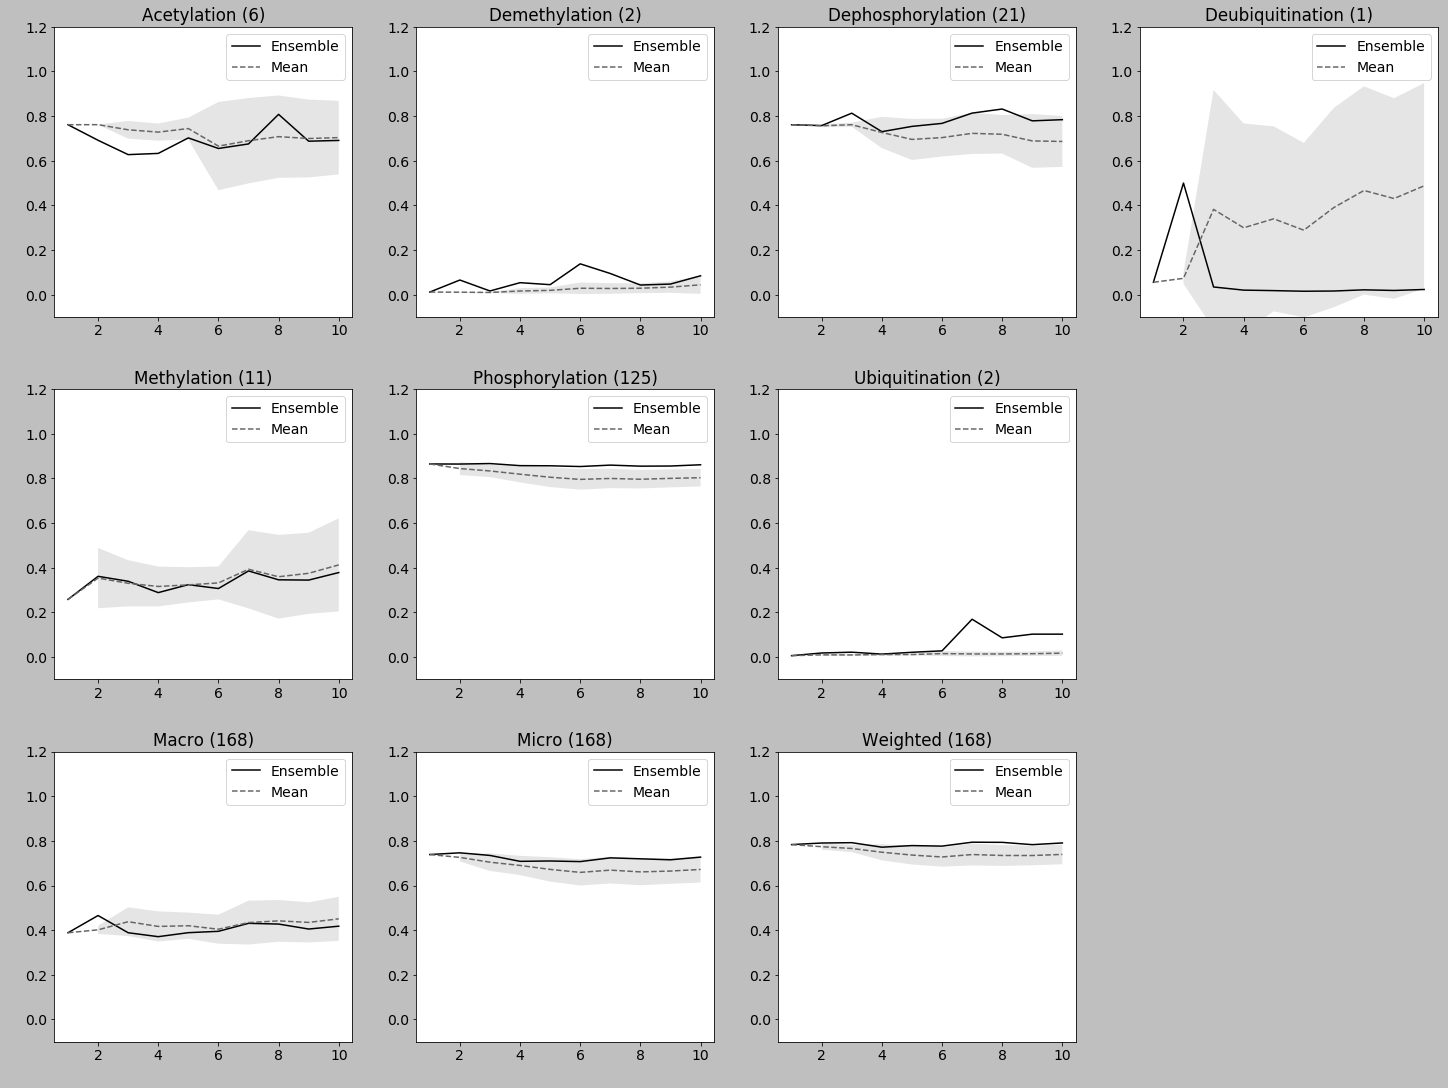

In [106]:
plot_ensemble_size_impact_pr(df_ensemble_pr_size_compare, df_pr_size_compare)

###  Compute optimal threshold

In [121]:
from sklearn.metrics import precision_recall_curve

def compute_threshold(df, normalise=True,  predicted_key="ensemble_predicted", predicted_key_confi=  "ensemble_predicted_confidence"):
    result = []
   
    if normalise:
        df = get_flattened_confidence_scores(df)
        predicted_key="predicted" 
        predicted_key_confi=  "predicted_confidence"


    pos_labels = df["actual"].unique().tolist()
    pos_labels.remove("other")

    y = label_binarize(df["actual"], classes=pos_labels)

    support =  df.query("actual != 'other'").shape[0]

    df_o_r = get_one_vs_rest_confidence(df, pos_labels,predicted_key, predicted_key_confi )

    for j, l in enumerate(pos_labels):
        precision, recall, thresholds = precision_recall_curve(y[:, j], df_o_r[pos_labels[j]])   
        
        # compute max precision = 
       
        p = max(precision[0:-1])
        pi = np.argmax(precision[0:-1])
        t = thresholds[pi]
        r = recall[pi]
#         print("--",l)
#         print(precision.round(4))
#         print(recall.round(4))
#         print(thresholds.round(4))
        
#         print(len(precision.round(4)), len(recall.round(4)), len(thresholds.round(4)))
        
        s =df[ df[l]  >= t].shape[0]
        percent = 100.0 * s/ df[ y[:, j] == 1].shape[0]
        
#        print(precision_score(df[ df[l]  > t]["actual"], df[ df[l]  > t]["ensemble_predicted"], labels=[l], average='macro'))
       
       
        result.append({"InteractionType": l, "Precision":p*100, "Recall":r*100, "Threshold":t, "NumPredictions":s,  "PredictionsPercent":percent})


   
    return pd.DataFrame(result)

In [122]:
df_ensemble_thresholds = compute_threshold(df_ensemble, normalise=False)
df_ensemble_thresholds

,InteractionType,NumPredictions,Precision,PredictionsPercent,Recall,Threshold
0,phosphorylation,76,100.000000,60.800000,60.800000,0.739113
1,dephosphorylation,1,100.000000,4.761905,4.761905,0.967031
2,acetylation,3,100.000000,50.000000,50.000000,0.859276
3,demethylation,0,14.285714,0.000000,50.000000,0.527745
4,methylation,3,100.000000,27.272727,27.272727,0.721591
5,ubiquitination,0,20.000000,0.000000,50.000000,0.571744
6,deubiquitination,1,2.325581,100.000000,100.000000,0.360909


In [109]:
print(df_ensemble_thresholds[["InteractionType",  "Precision", "Recall","Threshold" ]].sort_values(by="InteractionType").to_latex(index=False,formatters  = {"Threshold": lambda x: "{:.4f}".format(x), "Precision": lambda x: "{:.2f}".format(x), "Recall": lambda x: "{:.2f}".format(x)}))

\begin{tabular}{lrrr}
\toprule
   InteractionType & Precision & Recall & Threshold \\
\midrule
       acetylation &    100.00 &  50.00 &    0.8593 \\
     demethylation &     14.29 &  50.00 &    0.5277 \\
 dephosphorylation &    100.00 &   4.76 &    0.9670 \\
  deubiquitination &      2.33 & 100.00 &    0.3609 \\
       methylation &    100.00 &  27.27 &    0.7216 \\
   phosphorylation &    100.00 &  60.80 &    0.7391 \\
    ubiquitination &     20.00 &  50.00 &    0.5717 \\
\bottomrule
\end{tabular}



In [110]:
df_ensemble_thresholds[["InteractionType",  "Threshold" ]].to_dict(orient='records' )

[{'InteractionType': 'phosphorylation', 'Threshold': 0.73911322481},
 {'InteractionType': 'dephosphorylation', 'Threshold': 0.96703105569},
 {'InteractionType': 'acetylation', 'Threshold': 0.8592761814600001},
 {'InteractionType': 'demethylation', 'Threshold': 0.52774533063},
 {'InteractionType': 'methylation', 'Threshold': 0.7215910189300001},
 {'InteractionType': 'ubiquitination', 'Threshold': 0.5717439842500001},
 {'InteractionType': 'deubiquitination', 'Threshold': 0.36090918539000005}]